In [3]:
# For colab users
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/My Drive/capstone

/content/drive/My Drive/capstone


In [5]:
!pip install python-Levenshtein

     |████████████████████████████████| 51kB 2.8MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144792 sha256=f9bc43d9abc7df5b692e99904d43b245a2e974da0255078a000c24fcd4c62a01
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


In [6]:
import model as m

import argparse
import os
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.nn.utils import clip_grad_norm
import torchtext.data as data
import random
import matplotlib.pyplot as plt
from tqdm import notebook
from sklearn.model_selection import KFold

### train function

In [5]:
def train(config, train_iter, model, criterion, optimizer, epoch, dic, save_path, prob=0):
    global iteration, n_total, train_loss, n_bad_loss
    global init, best_val_loss, stop

    print("=> EPOCH {}".format(epoch))
    train_iter.init_epoch()
    for i, batch in notebook.tqdm(enumerate(train_iter), total=len(train_iter)):
        # TODO 
        # add noise to batch
        g = batch.grapheme
        # if random.random() > prob:
         #   g = grapheme_add_noise(0.1, g, dic)
        
        
        iteration += 1
        model.train()
        output, _, __ = model(g, batch.phoneme[:-1].detach())
        target = batch.phoneme[1:]
        # print(output.size())
        loss = criterion(output.view(output.size(0) * output.size(1), -1),
                         target.view(target.size(0) * target.size(1)))
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip, 'inf')
        optimizer.step()
        
        n_total += batch.batch_size
        train_loss += loss.data * batch.batch_size
        
        # print("   % Time: {:5.0f} | Iteration: {:5} | Batch: {:4}/{}"
        #           " | Train loss: {:.4f}"
        #           .format(time.time()-init, iteration, train_iter.iterations,
        #                   len(train_iter), train_loss))
        
        if iteration % config.log_every == 0:
            train_loss /= n_total
            val_loss = validate(val_iter, model, criterion)
            print("   % Time: {:5.0f} | Iteration: {:5} | Batch: {:4}/{}"
                  " | Train loss: {:.4f} | Val loss: {:.4f}"
                  .format(time.time()-init, iteration, train_iter.iterations,
                          len(train_iter), train_loss, val_loss))
            
            # test for val_loss improvement
            n_total = train_loss = 0
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                n_bad_loss = 0
                torch.save(model.state_dict(), save_path)
            else:
                n_bad_loss += 1
            if n_bad_loss == config.n_bad_loss:
                best_val_loss = val_loss
                n_bad_loss = 0
                m.adjust_learning_rate(optimizer, config.lr_decay)
                new_lr = optimizer.param_groups[0]['lr']
                print("=> Adjust learning rate to: {}".format(new_lr))
                if new_lr < config.lr_min:
                    stop = True
                    break

### Validation Function

In [6]:
def validate(val_iter, model, criterion):
    model.eval()
    val_loss = 0
    val_iter.init_epoch()
    for batch in val_iter:
        output, _, __ = model(batch.grapheme, batch.phoneme[:-1])
        target = batch.phoneme[1:]
        loss = criterion(output.squeeze(1), target.squeeze(1))
        val_loss += loss.data * batch.batch_size
    
    return val_loss / len(val_iter.dataset)

### Test Function

In [7]:
def test(test_iter, model, g_dic, p_dic, print_error=False):
    model.eval()
    test_iter.init_epoch()
    test_per = 0
    wrong = []
    with torch.no_grad():
        for batch in test_iter:
            output = model(batch.grapheme).data.tolist()
            target = batch.phoneme[1:].squeeze(1).data.tolist()
            # calculate per, wer here
            try:
                per = m.phoneme_error_rate(output[:output.index(3) + 1], target)
            except ValueError:
                per = m.phoneme_error_rate(output, target) 

            if per > 0:
                
                tmp = list([g_dic[g] for g in batch.grapheme])
                tmp.reverse()
                wrong.append(tmp)

                if print_error:        
                    print("Grapheme: {}\nTarget: {}\nPrediction: {}\n".format(
                      ''.join(tmp),
                      ' '.join([p_dic[p] for p in target]),
                      ' '.join([p_dic[p] for p in output])))

            test_per += per  # batch_size = 1
        
        test_per = test_per / len(test_iter.dataset) * 100
        print("Phoneme error rate (PER): {:.2f}\n"
              .format(test_per))
    
    return test_per, wrong

In [8]:
def print_result(model, lines, grapheme, g_dic, p_dic):
    g = grapheme[:-3]
    for line in lines:
        if line.strip().split()[0] == g:
            target = line.strip().split()[1:]

    input = [2]
    for letter in g:
        input.insert(1, g_dic.index(letter))
    input = torch.unsqueeze(torch.LongTensor(input).to("cuda"), 1)
    
    with torch.no_grad():

        output = model(input).data.tolist()

     
    print("Grapheme: {}\nTarget: {}\nPrediction: {}\n".format(
            g, ' '.join(target), ' '.join([p_dic[p] for p in output[:-1]]) ) )

## Set parameter

In [9]:
parser = {
    'num_row': -1, # modify num_row to -1 if you want to input all data points
    'epochs': 15,
    'batch_size': 128,
    'max_len': 20,  # max length of grapheme/phoneme sequences
    'beam_size': 5,  # size of beam for beam-search
    'd_embed': 30,  # embedding dimension
    'd_hidden': 256,  # hidden dimension
    'attention': True,  # use attention or not
    'log_every': 100,  # number of iterations to log and validate training
    'lr': 0.007,  # initial learning rate
    'lr_decay': 0.5,  # decay lr when not observing improvement in val_loss
    'lr_min': 5e-4,  # stop when lr is too low
    'n_bad_loss': 5,  # number of bad val_loss before decaying
    'clip': 2.3,  # clip gradient, to avoid exploding gradient
    'cuda': True,  # using gpu or not
    'seed': 1234,  # initial seed
}
args = argparse.Namespace(**parser)

In [10]:
args.cuda = args.cuda and torch.cuda.is_available()

# if not os.path.isdir(args.intermediate_path):
#     os.makedirs(args.intermediate_path)
# if not os.path.isdir(args.data_path):
#     os.makedirs(args.data_path)
#     URL = "https://github.com/cmusphinx/cmudict/archive/master.zip"
#     !wget $URL -O ./data/cmudict.zip
#     !unzip ./data/cmudict.zip -d ./data/
#     !mv ./data/cmudict-master $args.data_path

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

## split the data and build dataloader

In [11]:
import pandas as pd
import pickle
from sklearn import model_selection

In [12]:
df = pd.read_csv("filtered_no_stress_freq.csv", index_col=0)

In [13]:
df.head()

,word,frequency
0,'bout B AW T\n,1
1,'em AH M\n,41
2,'round R AW N D\n,5
3,'tis T IH Z\n,2
4,a AH\n,23195


In [14]:
kf = KFold(n_splits=10)

In [15]:
new_df = df.sample(frac=1, random_state=777)
kf.get_n_splits(new_df)

10

In [16]:
new_df.head()

,word,frequency
11153,fame F EY M\n,18
8225,derived D ER AY V D\n,39
21291,orthodontist AO R TH AH D AA N T AH S T\n,9
14817,humanities HH Y UW M AE N IH T IY Z\n,2
26477,sausage S AO S AH JH\n,1


In [17]:
# please rerun this line if you need to retrain the model!!!
cv_generator = kf.split(new_df)

In [18]:
e = 1
test_pers = []
for train_index, test_index in cv_generator:
    # data preparation
    print("data preparation for epoch " + str(e))
    train_set, val_set = model_selection.train_test_split(new_df.iloc[train_index,], test_size=0.2222, random_state=args.seed)
    test_set = new_df.iloc[test_index,]
    weight = np.clip(train_set["frequency"].tolist(), 0, 1000)
    np.random.seed(args.seed)
    train_lines = np.random.choice(train_set["word"].tolist(), size=100000, p=(np.array(weight) / sum(weight)) )
    val_lines = val_set["word"].tolist()
    test_lines = test_set["word"].tolist()
    train_iter, val_iter, test_iter, g_field, p_field = m.prepare_data(train_lines, val_lines, test_lines, args)
    dic = g_field.vocab.itos

    # Training
    #set up configuration
    print("Training for epoch " + str(e))
    config = args 
    config.g_size = len(g_field.vocab)
    config.p_size = len(p_field.vocab)
    config.d_hidden = 256 
    save_path = "model_para/cv_" + str(config.d_hidden) + "/best_model_" + str(config.d_hidden) + "_fold_" + str(e) + ".pt"
    
    model = m.G2P(config)
    criterion = nn.NLLLoss()
    if config.cuda:
        model.cuda()
        criterion.cuda()
    optimizer = optim.Adam(model.parameters(), lr=config.lr)  # use Adagrad
    
    # training
    iteration = n_total = train_loss = n_bad_loss = 0
    stop = False
    best_val_loss = 10
    init = time.time()

    # If you want to change epoch, uncomment the following line
    # config.epochs = 10

    for epoch in range(1, config.epochs+1):
        train(config, train_iter, model, criterion, optimizer, epoch, dic, save_path)
        if stop:
            break

    #calculate result
    test_per, mis_classified = test(test_iter, model, g_dic=g_field.vocab.itos, p_dic=p_field.vocab.itos)
    test_pers.append(test_per)

    # update epoch
    e = e + 1

data preparation for epoch 1
Training for epoch 1
=> EPOCH 1


   % Time:    29 | Iteration:   100 | Batch:  100/782 | Train loss: 1.0209 | Val loss: 1.5980
   % Time:    58 | Iteration:   200 | Batch:  200/782 | Train loss: 0.1648 | Val loss: 0.9587
   % Time:    86 | Iteration:   300 | Batch:  300/782 | Train loss: 0.0821 | Val loss: 0.8429
   % Time:   114 | Iteration:   400 | Batch:  400/782 | Train loss: 0.0611 | Val loss: 0.7750
   % Time:   141 | Iteration:   500 | Batch:  500/782 | Train loss: 0.0506 | Val loss: 0.7693
   % Time:   170 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0482 | Val loss: 0.7587
   % Time:   198 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0411 | Val loss: 0.7144

=> EPOCH 2


   % Time:   226 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0383 | Val loss: 0.7174
   % Time:   254 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0296 | Val loss: 0.7382
   % Time:   282 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0358 | Val loss: 0.7401
   % Time:   311 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0339 | Val loss: 0.7180
   % Time:   339 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0343 | Val loss: 0.7219
=> Adjust learning rate to: 0.0035
   % Time:   367 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0247 | Val loss: 0.6504
   % Time:   395 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0190 | Val loss: 0.6382
   % Time:   424 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0180 | Val loss: 0.6006

=> EPOCH 3


   % Time:   452 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0143 | Val loss: 0.5472
   % Time:   480 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0106 | Val loss: 0.5620
   % Time:   508 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0110 | Val loss: 0.5846
   % Time:   536 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0103 | Val loss: 0.5881
   % Time:   564 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0106 | Val loss: 0.5816
   % Time:   593 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0108 | Val loss: 0.6098
=> Adjust learning rate to: 0.00175
   % Time:   622 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0096 | Val loss: 0.5971
   % Time:   650 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0081 | Val loss: 0.6014

=> EPOCH 4


   % Time:   678 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0058 | Val loss: 0.6082
   % Time:   705 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0042 | Val loss: 0.6076
   % Time:   732 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0036 | Val loss: 0.6021
   % Time:   761 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0040 | Val loss: 0.5858
   % Time:   788 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0041 | Val loss: 0.6044
   % Time:   816 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0037 | Val loss: 0.5993
   % Time:   843 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0039 | Val loss: 0.5989
   % Time:   872 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0042 | Val loss: 0.6169

=> EPOCH 5


   % Time:   900 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0034 | Val loss: 0.5943
=> Adjust learning rate to: 0.000875
   % Time:   927 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0023 | Val loss: 0.5923
   % Time:   955 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0019 | Val loss: 0.5934
   % Time:   983 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0018 | Val loss: 0.5990
   % Time:  1010 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0020 | Val loss: 0.5986
   % Time:  1038 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0021 | Val loss: 0.6011
   % Time:  1066 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0019 | Val loss: 0.5977
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 14.31

data preparation for epoch 2
Training for epoch 2
=> EPOCH 1


   % Time:    28 | Iteration:   100 | Batch:  100/782 | Train loss: 1.0280 | Val loss: 1.3016
   % Time:    56 | Iteration:   200 | Batch:  200/782 | Train loss: 0.1546 | Val loss: 0.8628
   % Time:    84 | Iteration:   300 | Batch:  300/782 | Train loss: 0.0783 | Val loss: 0.7896
   % Time:   113 | Iteration:   400 | Batch:  400/782 | Train loss: 0.0612 | Val loss: 0.8327
   % Time:   140 | Iteration:   500 | Batch:  500/782 | Train loss: 0.0526 | Val loss: 0.7996
   % Time:   169 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0491 | Val loss: 0.7727
   % Time:   197 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0429 | Val loss: 0.7484

=> EPOCH 2


   % Time:   225 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0406 | Val loss: 0.7949
   % Time:   254 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0329 | Val loss: 0.7348
   % Time:   282 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0317 | Val loss: 0.7511
   % Time:   309 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0320 | Val loss: 0.6843
   % Time:   337 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0313 | Val loss: 0.7163
   % Time:   365 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0342 | Val loss: 0.6949
   % Time:   394 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0300 | Val loss: 0.6857
   % Time:   422 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0301 | Val loss: 0.6735

=> EPOCH 3


   % Time:   450 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0283 | Val loss: 0.7753
   % Time:   477 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0270 | Val loss: 0.7500
   % Time:   506 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0262 | Val loss: 0.7514
   % Time:   534 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0265 | Val loss: 0.7871
   % Time:   561 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0288 | Val loss: 0.7402
=> Adjust learning rate to: 0.0035
   % Time:   589 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0205 | Val loss: 0.7047
   % Time:   616 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0160 | Val loss: 0.6962
   % Time:   644 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0141 | Val loss: 0.6445

=> EPOCH 4


   % Time:   672 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0112 | Val loss: 0.6235
   % Time:   700 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0081 | Val loss: 0.6634
   % Time:   728 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0071 | Val loss: 0.6522
   % Time:   755 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0077 | Val loss: 0.6571
   % Time:   783 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0086 | Val loss: 0.6395
   % Time:   811 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0078 | Val loss: 0.6586
=> Adjust learning rate to: 0.00175
   % Time:   840 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0067 | Val loss: 0.6573
   % Time:   868 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0069 | Val loss: 0.6579

=> EPOCH 5


   % Time:   895 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0037 | Val loss: 0.6591
   % Time:   924 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0026 | Val loss: 0.6569
   % Time:   952 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0030 | Val loss: 0.6510
   % Time:   980 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0025 | Val loss: 0.6565
   % Time:  1007 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0029 | Val loss: 0.6709
   % Time:  1035 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0031 | Val loss: 0.6586
   % Time:  1063 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0030 | Val loss: 0.6711
   % Time:  1090 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0029 | Val loss: 0.6662
=> Adjust learning rate to: 0.000875

=> EPOCH 6


   % Time:  1119 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0015 | Val loss: 0.6638
   % Time:  1147 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0012 | Val loss: 0.6632
   % Time:  1174 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0013 | Val loss: 0.6709
   % Time:  1203 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0013 | Val loss: 0.6815
   % Time:  1231 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0013 | Val loss: 0.6802
   % Time:  1258 | Iteration:  4500 | Batch:  590/782 | Train loss: 0.0010 | Val loss: 0.6843
   % Time:  1286 | Iteration:  4600 | Batch:  690/782 | Train loss: 0.0010 | Val loss: 0.6872
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 14.05

data preparation for epoch 3
Training for epoch 3
=> EPOCH 1


   % Time:    27 | Iteration:   100 | Batch:  100/782 | Train loss: 1.0440 | Val loss: 1.1809
   % Time:    56 | Iteration:   200 | Batch:  200/782 | Train loss: 0.1545 | Val loss: 0.8338
   % Time:    84 | Iteration:   300 | Batch:  300/782 | Train loss: 0.0760 | Val loss: 0.8156
   % Time:   112 | Iteration:   400 | Batch:  400/782 | Train loss: 0.0633 | Val loss: 0.7292
   % Time:   140 | Iteration:   500 | Batch:  500/782 | Train loss: 0.0523 | Val loss: 0.6467
   % Time:   168 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0424 | Val loss: 0.7539
   % Time:   196 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0375 | Val loss: 0.6879

=> EPOCH 2


   % Time:   223 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0387 | Val loss: 0.6496
   % Time:   251 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0333 | Val loss: 0.6741
   % Time:   279 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0329 | Val loss: 0.6544
=> Adjust learning rate to: 0.0035
   % Time:   307 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0242 | Val loss: 0.5856
   % Time:   335 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0197 | Val loss: 0.5876
   % Time:   362 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0178 | Val loss: 0.5634
   % Time:   389 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0171 | Val loss: 0.5557
   % Time:   417 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0161 | Val loss: 0.5706

=> EPOCH 3


   % Time:   445 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0134 | Val loss: 0.5616
   % Time:   473 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0092 | Val loss: 0.5743
   % Time:   501 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0098 | Val loss: 0.5861
   % Time:   529 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0105 | Val loss: 0.5803
=> Adjust learning rate to: 0.00175
   % Time:   557 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0091 | Val loss: 0.5568
   % Time:   584 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0078 | Val loss: 0.5398
   % Time:   612 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0072 | Val loss: 0.5428
   % Time:   640 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0069 | Val loss: 0.5392

=> EPOCH 4


   % Time:   669 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0051 | Val loss: 0.5372
   % Time:   697 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0035 | Val loss: 0.5517
   % Time:   726 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0035 | Val loss: 0.5448
   % Time:   754 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0037 | Val loss: 0.5469
   % Time:   782 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0044 | Val loss: 0.5559
   % Time:   810 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0040 | Val loss: 0.5552
=> Adjust learning rate to: 0.000875
   % Time:   837 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0040 | Val loss: 0.5542
   % Time:   865 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0037 | Val loss: 0.5477

=> EPOCH 5


   % Time:   893 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0021 | Val loss: 0.5538
   % Time:   921 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0018 | Val loss: 0.5495
   % Time:   949 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0016 | Val loss: 0.5543
   % Time:   977 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0018 | Val loss: 0.5536
   % Time:  1005 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0017 | Val loss: 0.5560
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 13.86

data preparation for epoch 4
Training for epoch 4
=> EPOCH 1


   % Time:    29 | Iteration:   100 | Batch:  100/782 | Train loss: 1.0761 | Val loss: 1.3461
   % Time:    58 | Iteration:   200 | Batch:  200/782 | Train loss: 0.1616 | Val loss: 0.8817
   % Time:    85 | Iteration:   300 | Batch:  300/782 | Train loss: 0.0826 | Val loss: 0.8117
   % Time:   113 | Iteration:   400 | Batch:  400/782 | Train loss: 0.0607 | Val loss: 0.7880
   % Time:   141 | Iteration:   500 | Batch:  500/782 | Train loss: 0.0529 | Val loss: 0.7356
   % Time:   169 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0472 | Val loss: 0.7517
   % Time:   197 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0435 | Val loss: 0.7872

=> EPOCH 2


   % Time:   224 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0370 | Val loss: 0.7363
   % Time:   252 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0338 | Val loss: 0.7707
   % Time:   280 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0325 | Val loss: 0.8226
=> Adjust learning rate to: 0.0035
   % Time:   310 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0246 | Val loss: 0.7361
   % Time:   338 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0199 | Val loss: 0.6698
   % Time:   366 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0187 | Val loss: 0.6301
   % Time:   395 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0183 | Val loss: 0.6344
   % Time:   424 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0168 | Val loss: 0.5960

=> EPOCH 3


   % Time:   453 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0141 | Val loss: 0.6297
   % Time:   482 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0105 | Val loss: 0.6109
   % Time:   511 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0110 | Val loss: 0.6358
   % Time:   541 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0108 | Val loss: 0.6457
   % Time:   571 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0113 | Val loss: 0.6399
=> Adjust learning rate to: 0.00175
   % Time:   601 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0108 | Val loss: 0.6286
   % Time:   631 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0087 | Val loss: 0.6358
   % Time:   660 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0084 | Val loss: 0.6312

=> EPOCH 4


   % Time:   690 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0062 | Val loss: 0.6237
   % Time:   719 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0042 | Val loss: 0.6303
   % Time:   748 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0042 | Val loss: 0.6262
   % Time:   778 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0043 | Val loss: 0.6074
   % Time:   808 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0052 | Val loss: 0.5850
   % Time:   838 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0046 | Val loss: 0.6087
   % Time:   867 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0047 | Val loss: 0.6056
   % Time:   897 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0048 | Val loss: 0.6309

=> EPOCH 5


   % Time:   927 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0035 | Val loss: 0.6305
   % Time:   955 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0034 | Val loss: 0.6314
=> Adjust learning rate to: 0.000875
   % Time:   986 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0027 | Val loss: 0.6207
   % Time:  1016 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0028 | Val loss: 0.6197
   % Time:  1046 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0024 | Val loss: 0.6262
   % Time:  1076 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0023 | Val loss: 0.6093
   % Time:  1105 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0023 | Val loss: 0.6099
   % Time:  1135 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0023 | Val loss: 0.6120

=> EPOCH 6


   % Time:  1165 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0013 | Val loss: 0.6090
   % Time:  1194 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0012 | Val loss: 0.6034
   % Time:  1224 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0013 | Val loss: 0.6280
   % Time:  1254 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0017 | Val loss: 0.6184
   % Time:  1284 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0018 | Val loss: 0.6159
   % Time:  1314 | Iteration:  4500 | Batch:  590/782 | Train loss: 0.0013 | Val loss: 0.6209
   % Time:  1344 | Iteration:  4600 | Batch:  690/782 | Train loss: 0.0013 | Val loss: 0.6046
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 13.84

data preparation for epoch 5
Training for epoch 5
=> EPOCH 1


   % Time:    30 | Iteration:   100 | Batch:  100/782 | Train loss: 1.0546 | Val loss: 1.1588
   % Time:    59 | Iteration:   200 | Batch:  200/782 | Train loss: 0.1752 | Val loss: 0.5526
   % Time:    89 | Iteration:   300 | Batch:  300/782 | Train loss: 0.0877 | Val loss: 0.4914
   % Time:   118 | Iteration:   400 | Batch:  400/782 | Train loss: 0.0667 | Val loss: 0.4658
   % Time:   148 | Iteration:   500 | Batch:  500/782 | Train loss: 0.0569 | Val loss: 0.4275
   % Time:   178 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0472 | Val loss: 0.4034
   % Time:   208 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0456 | Val loss: 0.4134

=> EPOCH 2


   % Time:   238 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0398 | Val loss: 0.4174
   % Time:   267 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0326 | Val loss: 0.4156
   % Time:   297 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0344 | Val loss: 0.4239
   % Time:   326 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0348 | Val loss: 0.4256
=> Adjust learning rate to: 0.0035
   % Time:   356 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0251 | Val loss: 0.3676
   % Time:   386 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0193 | Val loss: 0.3674
   % Time:   416 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0186 | Val loss: 0.3416
   % Time:   446 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0174 | Val loss: 0.3402

=> EPOCH 3


   % Time:   477 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0153 | Val loss: 0.3394
   % Time:   507 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0111 | Val loss: 0.3538
   % Time:   537 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0105 | Val loss: 0.3549
   % Time:   567 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0110 | Val loss: 0.3658
   % Time:   596 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0111 | Val loss: 0.3687
   % Time:   627 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0123 | Val loss: 0.3825
=> Adjust learning rate to: 0.00175
   % Time:   658 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0096 | Val loss: 0.3509
   % Time:   688 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0085 | Val loss: 0.3579

=> EPOCH 4


   % Time:   718 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0067 | Val loss: 0.3424
   % Time:   748 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0044 | Val loss: 0.3495
   % Time:   778 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0043 | Val loss: 0.3484
   % Time:   808 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0045 | Val loss: 0.3663
   % Time:   837 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0046 | Val loss: 0.3664
   % Time:   867 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0041 | Val loss: 0.3682
=> Adjust learning rate to: 0.000875
   % Time:   896 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0045 | Val loss: 0.3589
   % Time:   926 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0036 | Val loss: 0.3554

=> EPOCH 5


   % Time:   956 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0024 | Val loss: 0.3558
   % Time:   986 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0018 | Val loss: 0.3612
   % Time:  1017 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0020 | Val loss: 0.3652
   % Time:  1047 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0022 | Val loss: 0.3658
   % Time:  1078 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0022 | Val loss: 0.3639
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 8.62

data preparation for epoch 6
Training for epoch 6
=> EPOCH 1


   % Time:    31 | Iteration:   100 | Batch:  100/782 | Train loss: 0.9925 | Val loss: 1.3191
   % Time:    62 | Iteration:   200 | Batch:  200/782 | Train loss: 0.1488 | Val loss: 0.7841
   % Time:    91 | Iteration:   300 | Batch:  300/782 | Train loss: 0.0745 | Val loss: 0.7586
   % Time:   123 | Iteration:   400 | Batch:  400/782 | Train loss: 0.0578 | Val loss: 0.7958
   % Time:   152 | Iteration:   500 | Batch:  500/782 | Train loss: 0.0486 | Val loss: 0.7389
   % Time:   182 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0430 | Val loss: 0.6989
   % Time:   211 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0404 | Val loss: 0.6872

=> EPOCH 2


   % Time:   240 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0346 | Val loss: 0.7528
   % Time:   269 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0317 | Val loss: 0.6653
   % Time:   296 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0312 | Val loss: 0.7130
   % Time:   325 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0320 | Val loss: 0.7303
   % Time:   353 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0324 | Val loss: 0.6485
   % Time:   380 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0317 | Val loss: 0.6478
   % Time:   407 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0302 | Val loss: 0.6769
   % Time:   435 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0294 | Val loss: 0.6466

=> EPOCH 3


   % Time:   462 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0273 | Val loss: 0.6747
   % Time:   489 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0229 | Val loss: 0.7253
   % Time:   518 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0271 | Val loss: 0.7322
   % Time:   545 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0303 | Val loss: 0.7206
   % Time:   572 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0293 | Val loss: 0.7637
=> Adjust learning rate to: 0.0035
   % Time:   600 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0218 | Val loss: 0.6275
   % Time:   628 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0167 | Val loss: 0.6018
   % Time:   656 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0158 | Val loss: 0.5761

=> EPOCH 4


   % Time:   684 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0121 | Val loss: 0.5459
   % Time:   710 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0090 | Val loss: 0.5354
   % Time:   738 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0085 | Val loss: 0.5436
   % Time:   766 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0078 | Val loss: 0.5532
   % Time:   793 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0087 | Val loss: 0.5542
   % Time:   821 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0092 | Val loss: 0.5629
   % Time:   848 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0082 | Val loss: 0.5494
=> Adjust learning rate to: 0.00175
   % Time:   876 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0074 | Val loss: 0.5402

=> EPOCH 5


   % Time:   904 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0044 | Val loss: 0.5446
   % Time:   932 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0034 | Val loss: 0.5383
   % Time:   958 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0034 | Val loss: 0.5488
   % Time:   986 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0028 | Val loss: 0.5516
   % Time:  1014 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0033 | Val loss: 0.5501
   % Time:  1042 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0031 | Val loss: 0.5677
   % Time:  1069 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0033 | Val loss: 0.5722
=> Adjust learning rate to: 0.000875
   % Time:  1098 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0029 | Val loss: 0.5633

=> EPOCH 6


   % Time:  1126 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0015 | Val loss: 0.5632
   % Time:  1154 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0014 | Val loss: 0.5539
   % Time:  1182 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0014 | Val loss: 0.5533
   % Time:  1210 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0012 | Val loss: 0.5547
   % Time:  1238 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0010 | Val loss: 0.5562
   % Time:  1265 | Iteration:  4500 | Batch:  590/782 | Train loss: 0.0016 | Val loss: 0.5566
   % Time:  1294 | Iteration:  4600 | Batch:  690/782 | Train loss: 0.0010 | Val loss: 0.5624

=> EPOCH 7


   % Time:  1321 | Iteration:  4700 | Batch:    8/782 | Train loss: 0.0013 | Val loss: 0.5650
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 12.21

data preparation for epoch 7
Training for epoch 7
=> EPOCH 1


   % Time:    27 | Iteration:   100 | Batch:  100/782 | Train loss: 0.9938 | Val loss: 1.1731
   % Time:    54 | Iteration:   200 | Batch:  200/782 | Train loss: 0.1538 | Val loss: 0.9542
   % Time:    82 | Iteration:   300 | Batch:  300/782 | Train loss: 0.0785 | Val loss: 0.8705
   % Time:   110 | Iteration:   400 | Batch:  400/782 | Train loss: 0.0571 | Val loss: 0.7363
   % Time:   137 | Iteration:   500 | Batch:  500/782 | Train loss: 0.0514 | Val loss: 0.6876
   % Time:   165 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0409 | Val loss: 0.7814
   % Time:   192 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0401 | Val loss: 0.7068

=> EPOCH 2


   % Time:   219 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0373 | Val loss: 0.6838
   % Time:   246 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0326 | Val loss: 0.6912
   % Time:   274 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0318 | Val loss: 0.7471
   % Time:   302 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0323 | Val loss: 0.7543
   % Time:   329 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0309 | Val loss: 0.7045
   % Time:   357 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0322 | Val loss: 0.7259
=> Adjust learning rate to: 0.0035
   % Time:   385 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0264 | Val loss: 0.6737
   % Time:   412 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0182 | Val loss: 0.6300

=> EPOCH 3


   % Time:   440 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0159 | Val loss: 0.6042
   % Time:   467 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0105 | Val loss: 0.6389
   % Time:   495 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0103 | Val loss: 0.6318
   % Time:   522 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0108 | Val loss: 0.6274
   % Time:   549 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0102 | Val loss: 0.6276
   % Time:   577 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0101 | Val loss: 0.6209
=> Adjust learning rate to: 0.00175
   % Time:   605 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0087 | Val loss: 0.5949
   % Time:   633 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0087 | Val loss: 0.5898

=> EPOCH 4


   % Time:   660 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0065 | Val loss: 0.5490
   % Time:   688 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0034 | Val loss: 0.5594
   % Time:   716 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0043 | Val loss: 0.5613
   % Time:   744 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0037 | Val loss: 0.5630
   % Time:   771 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0035 | Val loss: 0.5730
   % Time:   799 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0038 | Val loss: 0.5731
=> Adjust learning rate to: 0.000875
   % Time:   827 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0037 | Val loss: 0.5687
   % Time:   854 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0039 | Val loss: 0.5597

=> EPOCH 5


   % Time:   883 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0023 | Val loss: 0.5647
   % Time:   910 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0019 | Val loss: 0.5659
   % Time:   938 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0020 | Val loss: 0.5764
   % Time:   965 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0015 | Val loss: 0.5686
   % Time:   992 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0016 | Val loss: 0.5747
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 14.23

data preparation for epoch 8
Training for epoch 8
=> EPOCH 1


   % Time:    29 | Iteration:   100 | Batch:  100/782 | Train loss: 1.0299 | Val loss: 1.2826
   % Time:    57 | Iteration:   200 | Batch:  200/782 | Train loss: 0.1690 | Val loss: 0.8560
   % Time:    83 | Iteration:   300 | Batch:  300/782 | Train loss: 0.0822 | Val loss: 0.8180
   % Time:   111 | Iteration:   400 | Batch:  400/782 | Train loss: 0.0581 | Val loss: 0.7108
   % Time:   139 | Iteration:   500 | Batch:  500/782 | Train loss: 0.0560 | Val loss: 0.7854
   % Time:   166 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0510 | Val loss: 0.6726
   % Time:   194 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0422 | Val loss: 0.6234

=> EPOCH 2


   % Time:   222 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0393 | Val loss: 0.6373
   % Time:   249 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0279 | Val loss: 0.6774
   % Time:   277 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0328 | Val loss: 0.7108
   % Time:   304 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0339 | Val loss: 0.6720
   % Time:   332 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0348 | Val loss: 0.6855
=> Adjust learning rate to: 0.0035
   % Time:   359 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0249 | Val loss: 0.5975
   % Time:   387 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0191 | Val loss: 0.5890
   % Time:   413 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0194 | Val loss: 0.5911

=> EPOCH 3


   % Time:   441 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0149 | Val loss: 0.5685
   % Time:   469 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0099 | Val loss: 0.6042
   % Time:   497 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0100 | Val loss: 0.5830
   % Time:   524 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0104 | Val loss: 0.5849
   % Time:   550 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0110 | Val loss: 0.5985
   % Time:   577 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0126 | Val loss: 0.5842
=> Adjust learning rate to: 0.00175
   % Time:   605 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0097 | Val loss: 0.5712
   % Time:   632 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0086 | Val loss: 0.5529

=> EPOCH 4


   % Time:   660 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0060 | Val loss: 0.5538
   % Time:   687 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0044 | Val loss: 0.5563
   % Time:   715 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0044 | Val loss: 0.5773
   % Time:   743 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0036 | Val loss: 0.5703
   % Time:   771 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0043 | Val loss: 0.5764
=> Adjust learning rate to: 0.000875
   % Time:   798 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0041 | Val loss: 0.5738
   % Time:   826 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0035 | Val loss: 0.5676
   % Time:   853 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0033 | Val loss: 0.5656

=> EPOCH 5


   % Time:   881 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0023 | Val loss: 0.5717
   % Time:   909 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0021 | Val loss: 0.5690
   % Time:   937 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0020 | Val loss: 0.5633
   % Time:   965 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0020 | Val loss: 0.5646
   % Time:   993 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0017 | Val loss: 0.5676
   % Time:  1021 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0015 | Val loss: 0.5724
   % Time:  1048 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0018 | Val loss: 0.5689
   % Time:  1077 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0021 | Val loss: 0.5726
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 12.80

data preparation for epoch 9
Training for epoch 9
=> EPOCH 1


   % Time:    28 | Iteration:   100 | Batch:  100/782 | Train loss: 1.0691 | Val loss: 1.1418
   % Time:    55 | Iteration:   200 | Batch:  200/782 | Train loss: 0.1598 | Val loss: 0.8153
   % Time:    83 | Iteration:   300 | Batch:  300/782 | Train loss: 0.0800 | Val loss: 0.7697
   % Time:   112 | Iteration:   400 | Batch:  400/782 | Train loss: 0.0544 | Val loss: 0.6968
   % Time:   140 | Iteration:   500 | Batch:  500/782 | Train loss: 0.0477 | Val loss: 0.7279
   % Time:   167 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0453 | Val loss: 0.7122
   % Time:   195 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0442 | Val loss: 0.7210

=> EPOCH 2


   % Time:   224 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0363 | Val loss: 0.6812
   % Time:   252 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0321 | Val loss: 0.6987
   % Time:   279 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0324 | Val loss: 0.6155
   % Time:   307 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0297 | Val loss: 0.6942
   % Time:   335 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0295 | Val loss: 0.6998
   % Time:   363 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0318 | Val loss: 0.7253
   % Time:   390 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0342 | Val loss: 0.6776
   % Time:   417 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0313 | Val loss: 0.7045
=> Adjust learning rate to: 0.0035

=> EPOCH 3


   % Time:   445 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0229 | Val loss: 0.6387
   % Time:   473 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0134 | Val loss: 0.6278
   % Time:   500 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0134 | Val loss: 0.6632
   % Time:   527 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0127 | Val loss: 0.6332
   % Time:   555 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0120 | Val loss: 0.6348
   % Time:   582 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0130 | Val loss: 0.6478
   % Time:   609 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0124 | Val loss: 0.6267
   % Time:   635 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0116 | Val loss: 0.6421

=> EPOCH 4


   % Time:   663 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0086 | Val loss: 0.6384
   % Time:   691 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0070 | Val loss: 0.6208
   % Time:   718 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0074 | Val loss: 0.5993
   % Time:   744 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0080 | Val loss: 0.5969
   % Time:   772 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0096 | Val loss: 0.6231
   % Time:   799 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0095 | Val loss: 0.5950
   % Time:   826 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0105 | Val loss: 0.6075
   % Time:   853 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0087 | Val loss: 0.6353

=> EPOCH 5


   % Time:   881 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0085 | Val loss: 0.6695
   % Time:   908 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0088 | Val loss: 0.6591
   % Time:   935 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0087 | Val loss: 0.6541
=> Adjust learning rate to: 0.00175
   % Time:   962 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0079 | Val loss: 0.6425
   % Time:   989 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0053 | Val loss: 0.6435
   % Time:  1016 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0059 | Val loss: 0.6082
   % Time:  1044 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0055 | Val loss: 0.5928
   % Time:  1072 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0044 | Val loss: 0.5841

=> EPOCH 6


   % Time:  1100 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0022 | Val loss: 0.5946
   % Time:  1127 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0018 | Val loss: 0.6061
   % Time:  1155 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0020 | Val loss: 0.6238
   % Time:  1182 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0026 | Val loss: 0.6198
   % Time:  1209 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0019 | Val loss: 0.6174
=> Adjust learning rate to: 0.000875
   % Time:  1237 | Iteration:  4500 | Batch:  590/782 | Train loss: 0.0019 | Val loss: 0.6210
   % Time:  1264 | Iteration:  4600 | Batch:  690/782 | Train loss: 0.0020 | Val loss: 0.6119

=> EPOCH 7


   % Time:  1292 | Iteration:  4700 | Batch:    8/782 | Train loss: 0.0018 | Val loss: 0.6157
   % Time:  1319 | Iteration:  4800 | Batch:  108/782 | Train loss: 0.0007 | Val loss: 0.6108
   % Time:  1346 | Iteration:  4900 | Batch:  208/782 | Train loss: 0.0008 | Val loss: 0.6128
   % Time:  1373 | Iteration:  5000 | Batch:  308/782 | Train loss: 0.0009 | Val loss: 0.6164
   % Time:  1401 | Iteration:  5100 | Batch:  408/782 | Train loss: 0.0008 | Val loss: 0.6131
   % Time:  1429 | Iteration:  5200 | Batch:  508/782 | Train loss: 0.0007 | Val loss: 0.6135
   % Time:  1456 | Iteration:  5300 | Batch:  608/782 | Train loss: 0.0008 | Val loss: 0.6254
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 12.93

data preparation for epoch 10
Training for epoch 10
=> EPOCH 1


   % Time:    28 | Iteration:   100 | Batch:  100/782 | Train loss: 1.0104 | Val loss: 1.6211
   % Time:    56 | Iteration:   200 | Batch:  200/782 | Train loss: 0.1535 | Val loss: 0.8965
   % Time:    84 | Iteration:   300 | Batch:  300/782 | Train loss: 0.0801 | Val loss: 0.7659
   % Time:   111 | Iteration:   400 | Batch:  400/782 | Train loss: 0.0621 | Val loss: 0.7679
   % Time:   139 | Iteration:   500 | Batch:  500/782 | Train loss: 0.0511 | Val loss: 0.7513
   % Time:   166 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0480 | Val loss: 0.6988
   % Time:   194 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0452 | Val loss: 0.7113

=> EPOCH 2


   % Time:   222 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0377 | Val loss: 0.7146
   % Time:   249 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0309 | Val loss: 0.6495
   % Time:   277 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0293 | Val loss: 0.6660
   % Time:   304 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0358 | Val loss: 0.6914
   % Time:   331 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0365 | Val loss: 0.6900
   % Time:   359 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0346 | Val loss: 0.6845
   % Time:   387 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0316 | Val loss: 0.6635
=> Adjust learning rate to: 0.0035
   % Time:   415 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0222 | Val loss: 0.6155

=> EPOCH 3


   % Time:   443 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0169 | Val loss: 0.5695
   % Time:   470 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0122 | Val loss: 0.5785
   % Time:   498 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0111 | Val loss: 0.5779
   % Time:   526 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0104 | Val loss: 0.5677
   % Time:   554 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0117 | Val loss: 0.5555
   % Time:   581 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0120 | Val loss: 0.5662
   % Time:   609 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0116 | Val loss: 0.5992
   % Time:   636 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0128 | Val loss: 0.5795

=> EPOCH 4


   % Time:   663 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0092 | Val loss: 0.5679
   % Time:   691 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0063 | Val loss: 0.5663
=> Adjust learning rate to: 0.00175
   % Time:   718 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0055 | Val loss: 0.5645
   % Time:   746 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0053 | Val loss: 0.5905
   % Time:   772 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0051 | Val loss: 0.5669
   % Time:   800 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0046 | Val loss: 0.5806
   % Time:   827 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0045 | Val loss: 0.5773
   % Time:   854 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0046 | Val loss: 0.5640

=> EPOCH 5


   % Time:   882 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0032 | Val loss: 0.5491
   % Time:   909 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0021 | Val loss: 0.5586
   % Time:   937 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0023 | Val loss: 0.5628
   % Time:   964 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0021 | Val loss: 0.5606
   % Time:   991 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0023 | Val loss: 0.5684
   % Time:  1020 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0027 | Val loss: 0.5791
=> Adjust learning rate to: 0.000875
   % Time:  1047 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0024 | Val loss: 0.5729
   % Time:  1074 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0021 | Val loss: 0.5763

=> EPOCH 6


   % Time:  1102 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0013 | Val loss: 0.5748
   % Time:  1128 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0010 | Val loss: 0.5792
   % Time:  1156 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0012 | Val loss: 0.5782
   % Time:  1183 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0010 | Val loss: 0.5799
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 13.17



In [8]:
test_pers = [14.31,14.05,13.86,13.84,8.62,12.21,14.23,12.80,12.93,13.17]

Text(0, 0.5, 'PER')

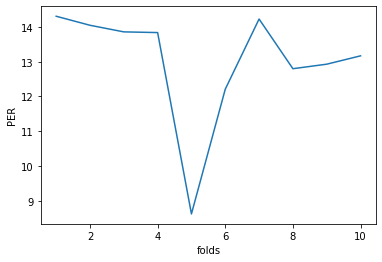

In [9]:
plt.plot(np.arange(1,11), test_pers)
plt.xlabel("folds")
plt.ylabel("PER")

In [10]:
print(np.mean(test_pers))

13.001999999999999


In [11]:
print(np.std(test_pers))

1.6018414403429575


In [12]:
test_pers

[14.31, 14.05, 13.86, 13.84, 8.62, 12.21, 14.23, 12.8, 12.93, 13.17]

In [13]:
np.mean(test_pers) + np.std(test_pers)

14.603841440342956